In [116]:
import matplotlib 
from matplotlib import pyplot as plt
import pylab as py
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits, ascii
from astropy import wcs
import scipy.ndimage as ndi
import numpy as np
from matplotlib.ticker import MultipleLocator,FuncFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from astropy.visualization import AsinhStretch, SqrtStretch, PercentileInterval
import pickle
from time import perf_counter as clock
from matplotlib import colors
import os
#from mpfit import mpfit
from scipy.optimize import curve_fit
import matplotlib as mpl

from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Ellipse, Circle

import warnings
warnings.filterwarnings("ignore")

## load data 

In [45]:
# load data and mask
Ha_region_data = fits.open('../data/SDSSj0228_ha_flux.fits')
Hb_region_data = fits.open('../data/SDSSj0228_hb_flux.fits')
O3_region_data = fits.open("../data/SDSSJ0228_O3_flux.fits")
S2_region_data = fits.open("../data/SDSSj0228_SII_flux.fits")
N2_region_data = fits.open('../data/SDSSj0228_haregion_flux_rebin.fits')

Hana_f     = Ha_region_data[1].data
Hana_f[np.isnan(Hana_f)] = 0
Habr_f     = Ha_region_data[3].data
Habr_f[np.isnan(Habr_f)] = 0
Hana_ferr  = Ha_region_data[2].data
Hana_ferr[np.isnan(Hana_ferr)] = 0
Habr_ferr  = Ha_region_data[4].data
Habr_ferr[np.isnan(Habr_ferr)] = 0
Ha_f       = Hana_f + Habr_f
Ha_ferr    = np.sqrt(Hana_ferr**2 + Habr_ferr**2)
ha_snr = Ha_f/Ha_ferr


N2b_f      = N2_region_data[3].data
N2b_f[np.isnan(N2b_f)] = 0
N2b_ferr   = N2_region_data[4].data
N2b_ferr[np.isnan(N2b_ferr)] = 0

S2a_f      = S2_region_data[1].data
S2a_f[np.isnan(S2a_f)] = 0
S2a_ferr   = S2_region_data[2].data
S2a_ferr[np.isnan(S2a_ferr)] = 0
S2b_f      = S2_region_data[3].data
S2b_f[np.isnan(S2b_f)] = 0
S2b_ferr   = S2_region_data[4].data
S2b_ferr[np.isnan(S2b_ferr)] = 0

S2_f       = S2a_f + S2b_f
S2_ferr    = np.sqrt(S2a_ferr**2 + S2b_ferr**2)

hbna_f     = Hb_region_data[1].data
hbna_f[np.isnan(hbna_f)] = 0
hbn_ferr   = Hb_region_data[2].data
hbn_ferr[np.isnan(hbn_ferr)] = 0
hbbr_f     = Hb_region_data[3].data
hbbr_f[np.isnan(hbbr_f)] = 0
hbbr_ferr  = Hb_region_data[4].data
hbbr_ferr[np.isnan(hbbr_ferr)] = 0

hb_flux     = hbna_f + hbbr_f
hb_flux_err = np.sqrt(hbn_ferr**2 + hbbr_ferr**2)

O3bna_f     = O3_region_data[2].data
O3bna_f[np.isnan(O3bna_f)] = 0
O3bna_ferr = O3_region_data[4].data
O3bna_ferr[np.isnan(O3bna_ferr)] = 0
O3bbr_f     = O3_region_data[6].data
O3bbr_f[np.isnan(O3bbr_f)] = 0
O3bbr_ferr = O3_region_data[8].data
O3bbr_ferr[np.isnan(O3bbr_ferr)] = 0

O3b_flux       = O3bna_f + O3bbr_f
O3b_flux_err   = np.sqrt(O3bna_ferr**2 + O3bbr_ferr**2)
snr_O3b        = O3b_flux/O3b_flux_err

O3a_naf        = O3_region_data[1].data
O3a_naf[np.isnan(O3a_naf)] = 0
O3a_naferr     = O3_region_data[3].data
O3a_naferr[np.isnan(O3a_naferr)] = 0
O3a_brf        = O3_region_data[5].data
O3a_brf[np.isnan(O3a_brf)] = 0
O3a_brferr     = O3_region_data[7].data
O3a_brferr[np.isnan(O3a_brferr)] = 0

O3a_flux       = O3a_naf + O3a_brf
O3a_flux_err   = np.sqrt(O3a_naferr**2 + O3a_brferr**2)
snr_O3a        = O3a_flux/O3b_flux_err

In [185]:
def dust_corr(Ha, Hb, line_wave, line_flux, E_BV=None, Ha2Hb=3.15, Rv=3.1, quiet=True):
    """ this function using (Ha / Hb) line ration to get the E(B-V) of the 
        reddening curves
    
    Params: 
        Ha, Hb: the flux of the Ha and Hb
        line_wave: the wavelength of correcting line, in um
        line_flux: the flux of the correcting line
        Ha2Hb: the theoretical ratio of Ha and Hb, default to 3.08 for AGN 
               and 2.86 for starforming galaxy
        Rv: effective total obscuration at V, default to 3.1 for Galactic 
            diffused ISM
    return:
        flux: the corrected flux the given emission line
    """
    from numpy.ma import is_masked
    if E_BV is None:
        Hb = np.ma.masked_less_equal(Hb, 1e-8).filled(np.inf)
        ratio_obs = np.ma.masked_less_equal(Ha/Hb, 1e-8).filled(Ha2Hb)
        # filled the masked value with 9999, to get rid of the warning  message
        E_BV = 1.97*np.log10(ratio_obs / Ha2Hb)
        if not quiet:
            if (E_BV < 0).any():
                print("Unphysical redcorr encountered!")
    E_BV = np.asarray(E_BV)
    E_BV[E_BV < 0] = 0
    # reddening curves using C00 (Calzetti 1999)
    if line_wave > 2.2 or line_wave < 0.12:
        raise ValueError("Wavelenth: {} is out of bound (0.12, 2.2)".format(
                         line_wave))
    elif line_wave < 0.63:
        k_lambda = 2.659*(-2.156+1.509/line_wave-0.198/line_wave**2 \
                   + 0.011/line_wave**3 ) + Rv
    else:
        k_lambda = 2.659*(-1.857+1.040/line_wave)+Rv
    flux_corr = line_flux*10**(0.4*k_lambda*E_BV)
    return np.asarray(flux_corr)

In [303]:
## de redden
BPT_map = fits.open("../../data/SDSSJ0228_BPT_type.fits")
F_Hb_na = np.zeros((50,50))
F_Hb_br = np.zeros((50,50))
F_Ha_na = np.zeros((50,50))
F_Ha_br = np.zeros((50,50))
F_O3a_na = np.zeros((50,50))
F_O3a_br = np.zeros((50,50))
F_O3b_na = np.zeros((50,50))
F_O3b_br = np.zeros((50,50))
F_N2_new = np.zeros((50,50))
F_S2_new = np.zeros((50,50))
for y in np.arange(50):
    for x in np.arange(50):
            
        F_Hb_na[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 4861*10**(-4), line_flux = hbna_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True) 
        F_Hb_br[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 4861*10**(-4), line_flux = hbbr_f[y,x], 
                          E_BV = None, Ha2Hb = 3.08, Rv = Rv, quiet = True) 
        
        F_Ha_na[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 6563*10**(-4), line_flux = Hana_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        F_Ha_br[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 6563*10**(-4), line_flux = Habr_f[y,x], 
                          E_BV = None, Ha2Hb = 3.08, Rv = Rv, quiet = True)

        F_O3a_na[y,x]  = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 4959*10**(-4), line_flux = O3a_naf[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        F_O3a_br[y,x]  = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 4959*10**(-4), line_flux = O3a_brf[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        
        F_O3b_na[y,x]  = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 5008*10**(-4), line_flux = O3bna_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        F_O3b_br[y,x]  = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 5008*10**(-4), line_flux = O3bbr_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        
        F_N2_new[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 6583*10**(-4), line_flux = N2b_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
        F_S2_new[y,x]   = dust_corr(Ha_f[y,x],hb_flux[y,x], line_wave = 6725*10**(-4), line_flux = S2_f[y,x], 
                          E_BV = None, Ha2Hb = 2.85, Rv = Rv, quiet = True)
    


In [285]:
input_emit = Table({'F_Hb_na':F_Hb_na.flatten(),'F_Hb_br':F_Hb_br.flatten(),'F_Ha_na':F_Ha_na.flatten(),'F_Ha_br':F_Ha_br.flatten(),
                    'F_O3a_na':F_O3a_na.flatten(),'F_O3a_br':F_O3a_br.flatten(),'F_O3b_na':F_O3b_na.flatten(),'F_O3b_br':F_O3b_br.flatten(),
                    'F_N2_new':F_N2_new.flatten(),'F_S2_new':F_S2_new.flatten()})
ascii.write(input_emit,"SDSSJ0228_redcorr_flux.dat",overwrite=True)

In [400]:
dist = 335.8 * 3.0856776 * 10**(24)    
F_Ha_t = np.full_like(F_Ha_na,np.nan)
Ha_cut_off = (ha_snr>3)
F_Ha_t[Ha_cut_off] = F_Ha_na[Ha_cut_off]
L_Ha_na = 4*np.pi*dist**2*np.nansum(F_Ha_t*10**(-20))
sfr_tol = 7.9*10**(-42)*L_Ha_na          ## SFR M_sun/yr
sfr_tol

1.516461233036317

## metalicity

In [329]:
# redcorr_data = ascii.read("SDSSJ0228_zinput_redcorr.dat")
hb_flux      = F_Hb_na                                                                                                       
O3a_flux     = F_O3a_na
O3b_flux     = F_O3b_na
N2b_flux     = F_N2_new
S2_flux      = F_S2_new

OIII_4959 = O3a_flux/hb_flux
OIII_5007 = O3b_flux/hb_flux
NII_6584  = N2b_flux/hb_flux
SII_6725  = S2_flux /hb_flux

eOIII_4959= np.sqrt((O3a_naferr  /hb_flux)**2+(O3a_flux*hbn_ferr/(hb_flux)**2)**2)
eOIII_5007= np.sqrt((O3bna_ferr  /hb_flux)**2+(O3b_flux*hbn_ferr/(hb_flux)**2)**2)
eNII_6584 = np.sqrt((N2b_ferr    /hb_flux)**2+(N2b_flux*hbn_ferr/(hb_flux)**2)**2)
eSII_6725 = np.sqrt((S2_ferr     /hb_flux)**2+(S2_flux *hbn_ferr/(hb_flux)**2)**2) 


In [330]:
OII_3727    = np.zeros((50*50))
eOII_3727   = np.zeros((50*50))

NeIII_3868  = np.zeros((50*50))
eNeIII_3868 = np.zeros((50*50))

OIII_4363   = np.zeros((50*50))
eOIII_4363  = np.zeros((50*50))

OIII_4959 = OIII_4959.flatten()
eOIII_4959 = eOIII_4959.flatten()

OIII_5007 = OIII_5007.flatten()
eOIII_5007 = eOIII_5007.flatten()

NII_6584  = NII_6584.flatten()
eNII_6584  = eNII_6584.flatten()

SII_6725  = SII_6725.flatten()
eSII_6725  = eSII_6725.flatten()

zerom = np.where(NII_6584<0)
OIII_4959[zerom] = 0
OIII_5007[zerom] = 0
NII_6584[zerom]  = 0
SII_6725[zerom]  = 0

eOIII_4959[zerom] = 0
eOIII_5007[zerom] = 0
eNII_6584[zerom]  = 0
eSII_6725[zerom]  = 0

from astropy.table import Table
input_emit = Table({'OII_3727':OII_3727,'eOII_3727':eOII_3727,'NeIII_3868':NeIII_3868,'eNeIII_3868':eNeIII_3868,'OIII_4363':OIII_4363,
                    'eOIII_4363':eOIII_4363,'OIII_4959':OIII_4959,'eOIII_4959':eOIII_4959,'OIII_5007':OIII_5007,'eOIII_5007':eOIII_5007,
                    'NII_6584':NII_6584,'eNII_6584':eNII_6584,'SII_6725':SII_6725,'eSII_6725':eSII_6725})
ascii.write(input_emit,"SDSSJ0228_input.dat",overwrite=True)

In [72]:
L_2500 = np.log10(2.7*10**42/(1.2*10**(15)))   # NED
nvL_2500 = L_2500+np.log10((3*10**5/(2500*10**(-10))))
L_x = np.log10(275)+40
a_ox   = -0.137*L_2500+2.638    # eq2. steffen et al.(2006); https://iopscience.iop.org/article/10.1086/503627/pdf
a_ox

-1.109249004981257

In [429]:
rebin_data_Ha = fits.open('../../analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
ppdata = fits.open("../../ppxf/SDSSJ0228/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]
BPT_map = fits.open("../../data/SDSSJ0228_BPT_type.fits")
BPT_type = BPT_map[1].data
sey_m = (BPT_type==1)
ha_wm = (pp_wave>6540)&(pp_wave<6580)
spec_con = rebin_data_Ha[3].data
Ha_ew = np.zeros((50,50))
for yy in np.arange(50):
    for xx in np.arange(50):
        Ha_flux = F_Ha_na[yy,xx]
        con = np.nanmedian(spec_con[:,yy,xx][ha_wm])
        Ha_ew[yy,xx] = Ha_flux/con
Ha_ew_new = np.full_like(Ha_ew,np.nan)
Ha_ew_new[snr_cut] = Ha_ew[snr_cut]
Ha_ew_new[sey_m] = np.nan

In [82]:
run HCm_v5.1.py SDSSJ0228_input.dat

 ---------------------------------------------------------------------
This is HII-CHI-mistry v. 5.1
 See Perez-Montero, E. (2014) for details
 Insert the name of your input text file with all or some of the following columns:
 3727 [OII], 3868 [NeIII], 4363 [OIII], 5007 [OIII], 6584 [NII], 6725 [SII]
with their corresponding labels and errors in adjacent columns
---------------------------------------------------------------------
The input file is:SDSSJ0228_input.dat

The number of iterations for MonteCarlo simulation is:  25


No interpolation for the AGN a(ox) = -0.8 models is going to be used.
The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

Reading grids ....


----------------------------------------------------------------
(%)   ID    Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
0.0 % 1 2  8.48 0.31  -1.24 0.52  -1.54 0.27
0.1 % 2 2  8.53 0.31  -1.2 0.44  -1.67 0.37
0.1 % 3 2  8.51 0.33  -1.27 0.4  -1.5

KeyboardInterrupt: 

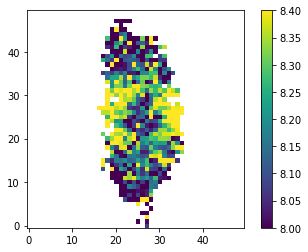

In [81]:
output_a12 = ascii.read("SDSSJ0228_hcm_sed4_output.dat")
Z_oh = np.array(output_a12['col15']).flatten()
Z_oh = Z_oh.reshape(50,50)
Z_oh_new = np.full_like(Z_oh,np.nan)
Z_oh_new [snr_cut] = Z_oh[snr_cut]
plt.imshow(Z_oh_new,vmin = 8.0, vmax = 8.4,origin='lower')
plt.colorbar()

In [55]:
output1 = ascii.read('SDSSJ0228_input.dat_hcm-output.dat')
Z_redcorr = np.array(output1['col15']).flatten()
Z_redcorr = Z_redcorr.reshape(50,50)
Z_redcorr[Z_redcorr==0]=np.nan
Z_err = np.array(output1['col16']).flatten()
Z_err = Z_err.reshape(50,50)
Z_err[Z_err==0]=np.nan
snr_cut = np.where(ha_snr>10)

Z_redcorr_new = np.full_like(Z_redcorr,np.nan)
Z_redcorr_new [snr_cut] = Z_redcorr[snr_cut]
Z_err_new = np.full_like(Z_err,np.nan)
Z_err_new[snr_cut] = Z_err[snr_cut]

output = ascii.read('SDSSJ0228_hcm_output_sed4.dat')
Z = np.array(output['col15']).flatten()
Z = Z.reshape(50,50)
Z[Z==0]=np.nan
snr_cut = np.where(ha_snr>10)
Z_new = np.full_like(Z,np.nan)
Z_new [snr_cut] = Z[snr_cut]

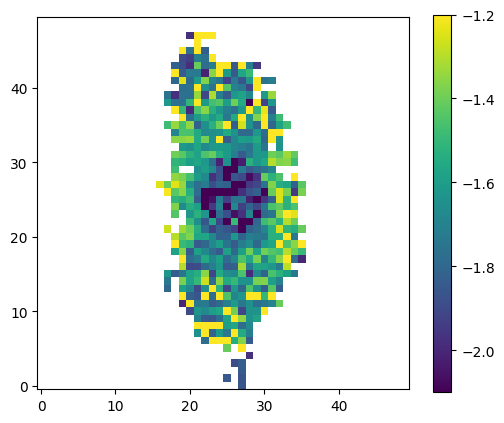

In [105]:
log_U = np.array(output1['col19']).flatten()
log_U = log_U.reshape(50,50)
log_U_new = np.full_like(log_U,np.nan)
log_U_new[snr_cut] = log_U[snr_cut]
plt.figure(figsize=(6,5),dpi = 100)
plt.imshow(log_U_new, origin='lower',vmin=-2.1, vmax=-1.2 )
plt.colorbar()

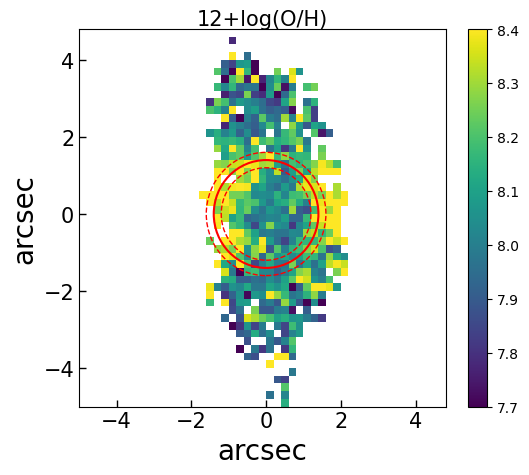

In [117]:
transform = AsinhStretch() + PercentileInterval(95)
fig = plt.figure(figsize=(13, 5),dpi=100)
matplotlib.rc('xtick',labelsize=10)
matplotlib.rc('ytick',labelsize=10)
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False
mpl.rcParams['axes.linewidth'] = 0.8
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
#fig.subplots_adjust(wspace=0.2, hspace=0.6)

nx = (np.arange(50) - 50/2)/5.
ny = (np.arange(50) - 50/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

# ax = plt.subplot(122)
# # ax.set_title('Ha EW',pad=1.5,fontsize=15)

# # ax.imshow(Ha_ew_new,vmin=0,vmax=25,origin='lower')

# # ax = plt.pcolormesh(xpos, ypos,Ha_ew_new,vmin=0,vmax=25)
# # plt.colorbar(ax)
# im=ax.imshow(Z_new, origin='lower',vmin=7.5,vmax=8.4)
# plt.colorbar(im)

# ax.tick_params(which='major',length=1.7,width=0.5)
# ax.tick_params(pad=1.3)

# ax.set_title('no-redcorr 12+log(O/H)',pad=1.5,fontsize=15)
# ax.text(0.04,0.9,('SDSSJ0228'),transform=ax.transAxes,fontdict={'size': '10', 'color': 'red'})

ax1 = plt.subplot(121)

# ax1.tick_params(which='major',length=1.7,width=0.5)
# ax1.tick_params(pad=1.3)
ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_title('12+log(O/H)',pad=1.5,fontsize=15)
ax1.set_xlabel('arcsec',fontsize=20)
ax1.set_ylabel('arcsec',fontsize=20)

cir1 = Circle(xy = (0.0, 0.0), radius=0.2*7, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax1.add_patch(cir1)

cir2 = Circle(xy = (0.0, 0.0), radius=0.2*6, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax1.add_patch(cir2)

cir3 = Circle(xy = (0.0, 0.0), radius=0.2*8, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax1.add_patch(cir3)



ax1 = plt.pcolormesh(xpos, ypos,Z_redcorr_new,vmin = 7.7, vmax = 8.4)

# im=ax1.imshow(Z_redcorr_new, origin='lower',vmin=7.7,vmax=8.4)

plt.colorbar(ax1)

plt.savefig('mentallicity.pdf',dpi=600,bbox_inches='tight')
# ax1.text(0.04,0.9,('SDSSJ0228'),transform=ax1.transAxes,fontdict={'size': '10', 'color': 'red'})

In [118]:
###header     velocity data 
# hdr = fits.Header()
# hdr['level0'] = 'header'
# hdr['level1'] = 'Z'
# hdr['level2'] = 'Z_err'
# hdr['COMMENT'] = "gas-phase metallicity from HCM5.1"

# empty_primary = fits.PrimaryHDU(header=hdr)

# ### flux, error, bestfit

# image_hdu1 = fits.ImageHDU(Z_redcorr)
# image_hdu2 = fits.ImageHDU(Z_err)


# hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2])
# hdul.writeto('../data/J0228_gas_fase_Z_HCM.fits', overwrite=True)

## compare with other methods

In [21]:
F_redcorr = ascii.read("SDSSJ0228_redcorr_flux.dat")
F_N2_new = F_redcorr["F_N2_new"]
F_Ha_na  = F_redcorr["F_Ha_na"]

In [252]:
## N2
N2_ind = np.log10(N2b_f/Hana_f)
N2_ind_err = np.sqrt((1/np.log(10) * (N2b_ferr/N2b_f))**2 + (1/np.log(10) * (Hana_ferr/Hana_f))**2)
Z_Zsun = 4.01**(N2_ind)-0.07
O_H_n2_c2020 = 8.69 + np.log10(Z_Zsun)

O_H_n2 = 8.743 + 0.462 * N2_ind
O_H_n2_err = 0.462 * N2_ind_err

OH_n2 = np.full_like(O_H_n2,np.nan)
OH_n2[snr_cut] = O_H_n2[snr_cut]
OH_n2_err = np.full_like(O_H_n2_err,np.nan)
OH_n2_err[snr_cut] = O_H_n2_err[snr_cut]

## O3N2 
O3_ind = np.log10(O3bna_f/hbna_f)
O3_ind_err = np.sqrt((1/np.log(10) * (O3bna_ferr/O3bna_f))**2 + (1/np.log(10) * (hbn_ferr/hbna_f))**2)
O3N2 = np.log10((O3bna_f/hbna_f)*(Hana_f/N2b_f))
O3N2_err = np.sqrt(O3_ind_err**2 + N2_ind_err**2)

O_H_o3n2 = 7.673 + 0.22 * np.sqrt(25.25 - 9.072 * O3N2) + 0.127 * O3_ind
O_H_o3n2_err = np.sqrt((-0.2*(1 - 0.36*O3N2)**(-0.5) * O3N2_err)**2+(0.127 * O3_ind_err)**2)

OH_o3n2 = np.full_like(O_H_o3n2,np.nan)
OH_o3n2[snr_cut] = O_H_o3n2[snr_cut]
OH_o3n2_err = np.full_like(O_H_o3n2_err,np.nan)
OH_o3n2_err[snr_cut] = O_H_o3n2_err[snr_cut]


## N2S2
# N2S2 = np.log10(F_N2_new/F_S2_new)
# O_H_n2s2 = 8.875+0.827*N2S2-0.288*N2S2**2

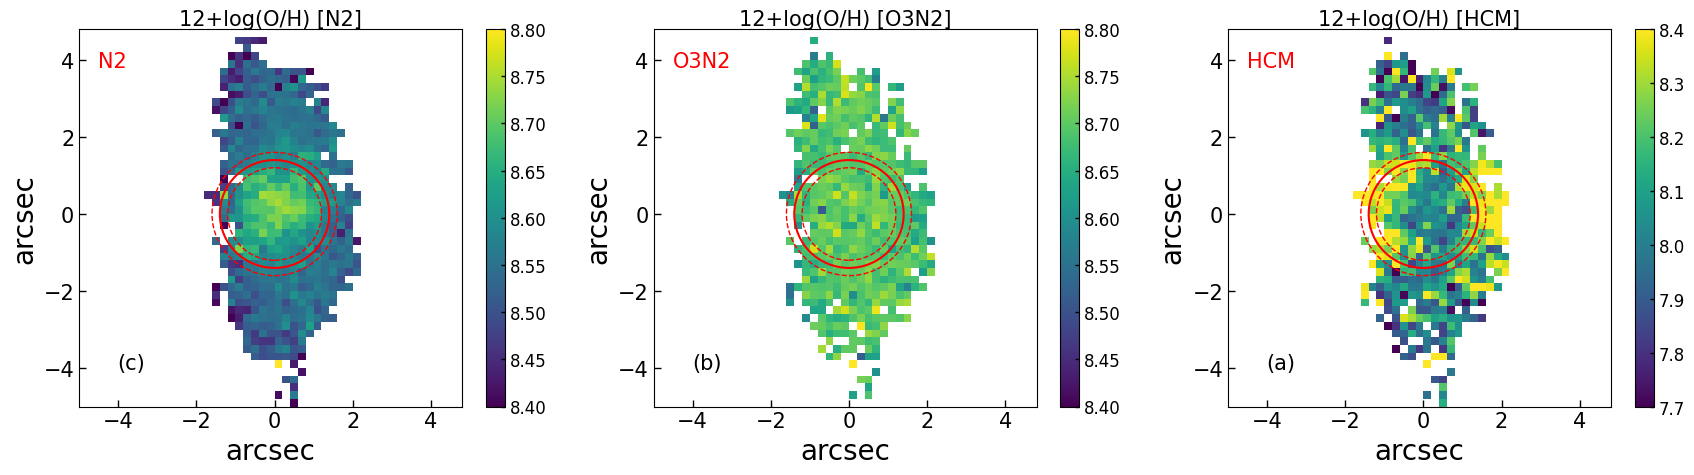

In [332]:
fig = plt.figure(figsize=(21, 5),dpi=100)
matplotlib.rc('xtick',labelsize=10)
matplotlib.rc('ytick',labelsize=10)
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False
mpl.rcParams['axes.linewidth'] = 0.8
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

nx = (np.arange(50) - 50/2)/5.
ny = (np.arange(50) - 50/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

ax1 = plt.subplot(133)

# ax1.tick_params(which='major',length=1.7,width=0.5)
# ax1.tick_params(pad=1.3)
ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_title('12+log(O/H) [HCM]',pad=1.5,fontsize=15)
ax1.set_xlabel('arcsec',fontsize=20)
ax1.set_ylabel('arcsec',fontsize=20)
ax1.text(0.1,0.1,'(a)',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'black'})
ax1.text(0.05,0.9,'HCM',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'red'})

cir1 = Circle(xy = (0.0, 0.0), radius=0.2*7, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax1.add_patch(cir1)
cir2 = Circle(xy = (0.0, 0.0), radius=0.2*6, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax1.add_patch(cir2)
cir3 = Circle(xy = (0.0, 0.0), radius=0.2*8, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax1.add_patch(cir3)

ax1 = plt.pcolormesh(xpos, ypos,Z_redcorr_new,vmin = 7.7, vmax = 8.4)
cb1 = plt.colorbar(ax1)
cb1.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)

ax2 = plt.subplot(132)
ax2.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax2.set_title('12+log(O/H) [O3N2]',pad=1.5,fontsize=15)
ax2.set_xlabel('arcsec',fontsize=20)
ax2.set_ylabel('arcsec',fontsize=20)
ax2.text(0.1,0.1,'(b)',transform=ax2.transAxes,fontdict={'size': '15', 'color': 'black'})
ax2.text(0.05,0.9,'O3N2',transform=ax2.transAxes,fontdict={'size': '15', 'color': 'red'})

cir1 = Circle(xy = (0.0, 0.0), radius=0.2*7, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax2.add_patch(cir1)
cir2 = Circle(xy = (0.0, 0.0), radius=0.2*6, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax2.add_patch(cir2)
cir3 = Circle(xy = (0.0, 0.0), radius=0.2*8, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax2.add_patch(cir3)

ax2 = plt.pcolormesh(xpos, ypos,OH_o3n2,vmin = 8.4, vmax = 8.8)
cb2 = plt.colorbar(ax2)
cb2.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)


ax3 = plt.subplot(131)
ax3.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax3.set_title('12+log(O/H) [N2]',pad=1.5,fontsize=15)
ax3.set_xlabel('arcsec',fontsize=20)
ax3.set_ylabel('arcsec',fontsize=20)
ax3.text(0.1,0.1,'(c)',transform=ax3.transAxes,fontdict={'size': '15', 'color': 'black'})
ax3.text(0.05,0.9,'N2',transform=ax3.transAxes,fontdict={'size': '15', 'color': 'red'})


cir1 = Circle(xy = (0.0, 0.0), radius=0.2*7, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax3.add_patch(cir1)
cir2 = Circle(xy = (0.0, 0.0), radius=0.2*6, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax3.add_patch(cir2)
cir3 = Circle(xy = (0.0, 0.0), radius=0.2*8, linestyle = '--',edgecolor = 'r',fc = 'none',lw = 1.0)
ax3.add_patch(cir3)

ax3 = plt.pcolormesh(xpos, ypos,OH_n2,vmin = 8.4, vmax = 8.8)
cb3 = plt.colorbar(ax3)
cb3.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)

plt.savefig('../image/metallicity_3method.pdf',dpi=600,bbox_inches='tight')

In [283]:
# major axis
OH_n2_maj = ((OH_n2[:,25]+np.flipud(OH_n2[:,25]))/2)[25:]
OH_n2_maj[16] = 8.53314
OH_n2_maj[19] = 8.49247
OH_n2_maj_err = ((OH_n2_err[:,25]+np.flipud(OH_n2_err[:,25]))/2)[25:]



OH_o3n2_maj = ((OH_o3n2[:,25]+np.flipud(OH_o3n2[:,25]))/2)[25:]
OH_o3n2_maj_err = ((OH_o3n2_err[:,25]+np.flipud(OH_o3n2_err[:,25]))/2)[25:]
OH_o3n2_maj_err[-4] = 0.135452

OH_hcm_maj = ((Z_redcorr_new[:,25]+np.flipud(Z_redcorr_new[:,25]))/2)[25:]
OH_hcm_maj_err = ((Z_err_new[:,25]+np.flipud(Z_err_new[:,25]))/2)[25:]

# minor axis
OH_n2_min = ((O_H_n2[25,:]+np.flipud(O_H_n2[25,:]))/2)[25:]
OH_n2_min_err = ((O_H_n2_err[25,:]+np.flipud(O_H_n2_err[25,:]))/2)[25:]

OH_o3n2_min = ((O_H_o3n2[25,:]+np.flipud(O_H_o3n2[25,:]))/2)[25:]
OH_o3n2_min_err = ((O_H_o3n2_err[25,:]+np.flipud(O_H_o3n2_err[25,:]))/2)[25:]

OH_hcm_min = ((Z_redcorr[25,:]+np.flipud(Z_redcorr[25,:]))/2)[25:]
OH_hcm_min_err = ((Z_err[25,:]+np.flipud(Z_err[25,:]))/2)[25:]

#############
Ne_data = ascii.read("../data/log_ne_major_axis.txt")
radius = Ne_data["Radius"]

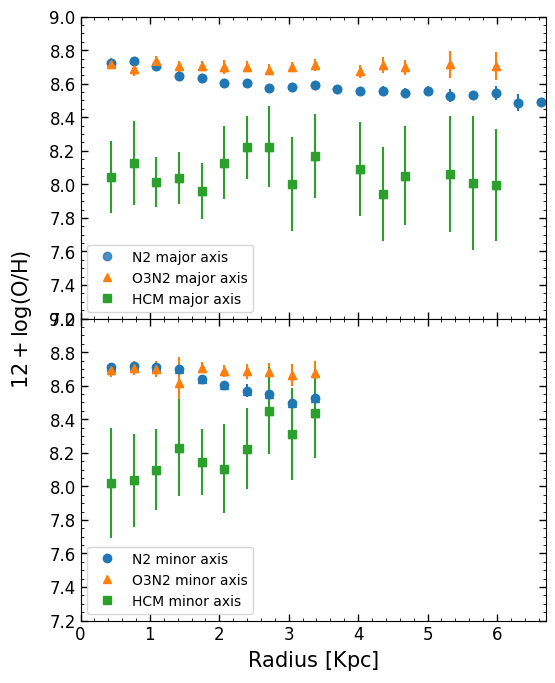

In [307]:
fig = plt.figure(figsize=(6,8),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.subplots_adjust(wspace=0,hspace=0)


ax1 = fig.add_subplot(211)
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax1.tick_params(labelbottom=False)

ax1.plot(radius,OH_n2_maj,"o",c="C0",alpha = 0.8, linestyle='None',label = "N2 major axis")
ax1.errorbar(radius,OH_n2_maj, yerr = OH_n2_maj_err, marker = 'o', color = "C0",  linestyle="None")

ax1.plot(radius,OH_o3n2_maj,"^",c="C1",linestyle='None',label = "O3N2 major axis")
ax1.errorbar(radius,OH_o3n2_maj, yerr = OH_o3n2_maj_err, marker = '^', color = "C1",  linestyle="None")

ax1.plot(radius,OH_hcm_maj,"s",c = "C2", linestyle='None',label = "HCM major axis")
ax1.errorbar(radius,OH_hcm_maj, yerr = OH_hcm_maj_err, marker = '^', color = "C2",  linestyle="None")

plt.ylim(7.2,9.0)
plt.xlim(0,6.7)
plt.legend(loc = "lower left")

ax2 = fig.add_subplot(212)
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)

ax2.plot(radius[0:10],OH_n2_min[0:10],"o",c="C0",linestyle='None',label = "N2 minor axis")
ax2.errorbar(radius[0:10],OH_n2_min[0:10], yerr = OH_n2_min_err[0:10], marker = '^', color = "C0",  linestyle="None")

ax2.plot(radius[0:10],OH_o3n2_min[0:10],"^",c="C1",linestyle='None',label = "O3N2 minor axis")
ax2.errorbar(radius[0:10],OH_o3n2_min[0:10], yerr = OH_o3n2_min_err[0:10], marker = '^', color = "C1",  linestyle="None")

ax2.plot(radius[0:10],OH_hcm_min[0:10],"s",c="C2",linestyle='None',label = "HCM minor axis")
ax2.errorbar(radius[0:10],OH_hcm_min[0:10], yerr = OH_hcm_min_err[0:10], marker = '^', color = "C2",  linestyle="None")

ax2.set_xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)
ax2.set_ylabel(r'${\rm 12+log(O/H)}$',fontsize=15)

ax2.yaxis.set_label_coords(-0.1,1)

plt.ylim(7.2,9.0)
plt.xlim(0,6.7)
plt.legend(loc = "lower left")

plt.savefig("../image/metallicity_grad.pdf", dpi=600,bbox_inches = 'tight')

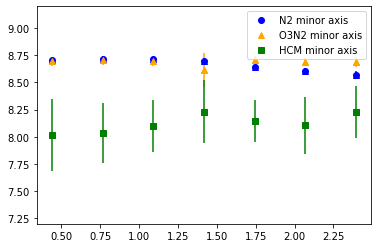

In [259]:
plt.plot(radius,OH_n2_min,"bo",linestyle='None',label = "N2 minor axis")
plt.errorbar(radius,OH_n2_min, yerr = OH_n2_min_err, marker = '^', color = "b",  linestyle="None")
plt.plot(radius,OH_o3n2_min,"^",c="orange",linestyle='None',label = "O3N2 minor axis")
plt.errorbar(radius,OH_o3n2_min, yerr = OH_o3n2_min_err, marker = '^', color = "orange",  linestyle="None")
plt.plot(radius,OH_hcm_min,"gs",linestyle='None',label = "HCM minor axis")
plt.errorbar(radius,OH_hcm_min, yerr = OH_hcm_min_err, marker = '^', color = "green",  linestyle="None")
plt.ylim(7.2,9.2)
# plt.xlim(0,3.36)
plt.legend()

In [277]:
0.336*5 *4

6.720000000000001

In [113]:
BPT_map = fits.open("../data/SDSSJ0228_BPT_type.fits")  # AGN = 1, LINER=2, Com = 3, SF = 4 
SF_xx = []
SF_yy = []
for y in np.arange(50):
    for x in np.arange(50):
        if BPT_map[1].data[y,x] == 4:
            SF_yy.append(y)
            SF_xx.append(x)

In [114]:
Z_hcm = []
Z_N2 = []
Z_O3N2 = []
for ii in np.arange(len(SF_xx)):
    xx = SF_xx[ii]
    yy = SF_yy[ii]
    Z_hcm.append(Z_redcorr_new[yy,xx])
    Z_N2.append(O_H_n2[yy,xx])
    Z_O3N2.append(O_H_o3n2[yy,xx])

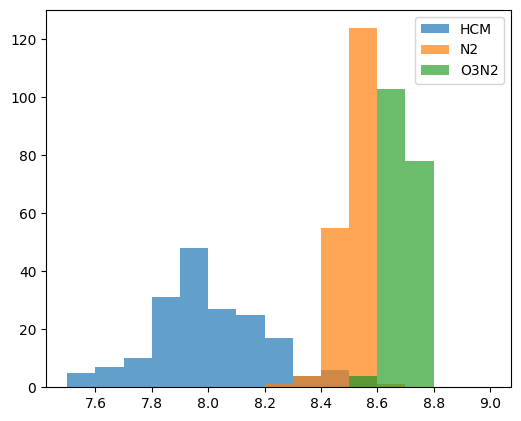

In [115]:
plt.figure(figsize=(6,5),dpi = 100)
bins = np.arange(7.5, 9.1, 0.1)
plt.hist(Z_hcm, bins = bins, label = 'HCM', alpha = 0.7)
plt.hist(Z_N2, bins = bins, label = 'N2', alpha = 0.7)
plt.hist(Z_O3N2, bins = bins, label = 'O3N2', alpha = 0.7)
plt.legend()